In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve,roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [9]:
df=pd.read_csv('https://raw.githubusercontent.com/training-ml/Files/main/titanic_train.csv')
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data preprocessing

In [20]:
# Unnamed: 0 and PassengerId columns are not necessary. So it can be deleted
df.drop(columns=['Unnamed: 0', 'PassengerId'], inplace=True)

In [5]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Outliers are probably less

In [6]:
# Find nulls 
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

There are nulls in age and cabin. Age will be a necessary feature as children and women were given preference in the survival group of titanic. We can exclude cabin as it seems unnecessary

In [22]:
df.drop(columns=['Cabin'], inplace=True)

In [23]:
# To fill nulls in age, we cannot use median/mode as it'll create false data.So, we could use the titles present in the name 
# column and calculate the median age for each set of titles and fill the nulls. 
# This would be more accurate than filling by median/mode

df['title']=df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: title, Length: 891, dtype: object

In [24]:
# find median of the age with respect to title and save as new variable
newage= df.groupby('title')['Age'].median()
newage

title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          46.5
Jonkheer    38.0
Lady        48.0
Major       48.5
Master       3.5
Miss        21.0
Mlle        24.0
Mme         24.0
Mr          30.0
Mrs         35.0
Ms          28.0
Rev         46.5
Sir         49.0
Name: Age, dtype: float64

In [25]:
# We can use map function to iterate over the newage and fill nulls using the corresponding age
df['Age'].fillna(df['title'].map(newage), inplace=True)
df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
title       0
dtype: int64

In [30]:
# title column isnt necessary now as our nulls were already filled in age column
df.drop(columns=['title'], inplace=True)

In [31]:
# Now, we can encode categorical variables using labelencoder
cat=df.select_dtypes(include='object')
cat=list(cat)
cat

['Name', 'Sex', 'Ticket', 'Embarked']

Name need not be encoded. Embarked means the boarding points which seem to be irrelevant.

In [32]:
df.drop(columns=['Name','Embarked'], inplace=True)

In [55]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for column in ['Sex', 'Ticket',]:
    if column in df.columns:
        df[column] = le.fit_transform(df[column])

In [56]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
0,0,3,1,22.0,1,0,523,7.2500
1,1,1,0,38.0,1,0,596,71.2833
2,1,3,0,26.0,0,0,669,7.9250
3,1,1,0,35.0,1,0,49,53.1000
4,0,3,1,35.0,0,0,472,8.0500


# EDA

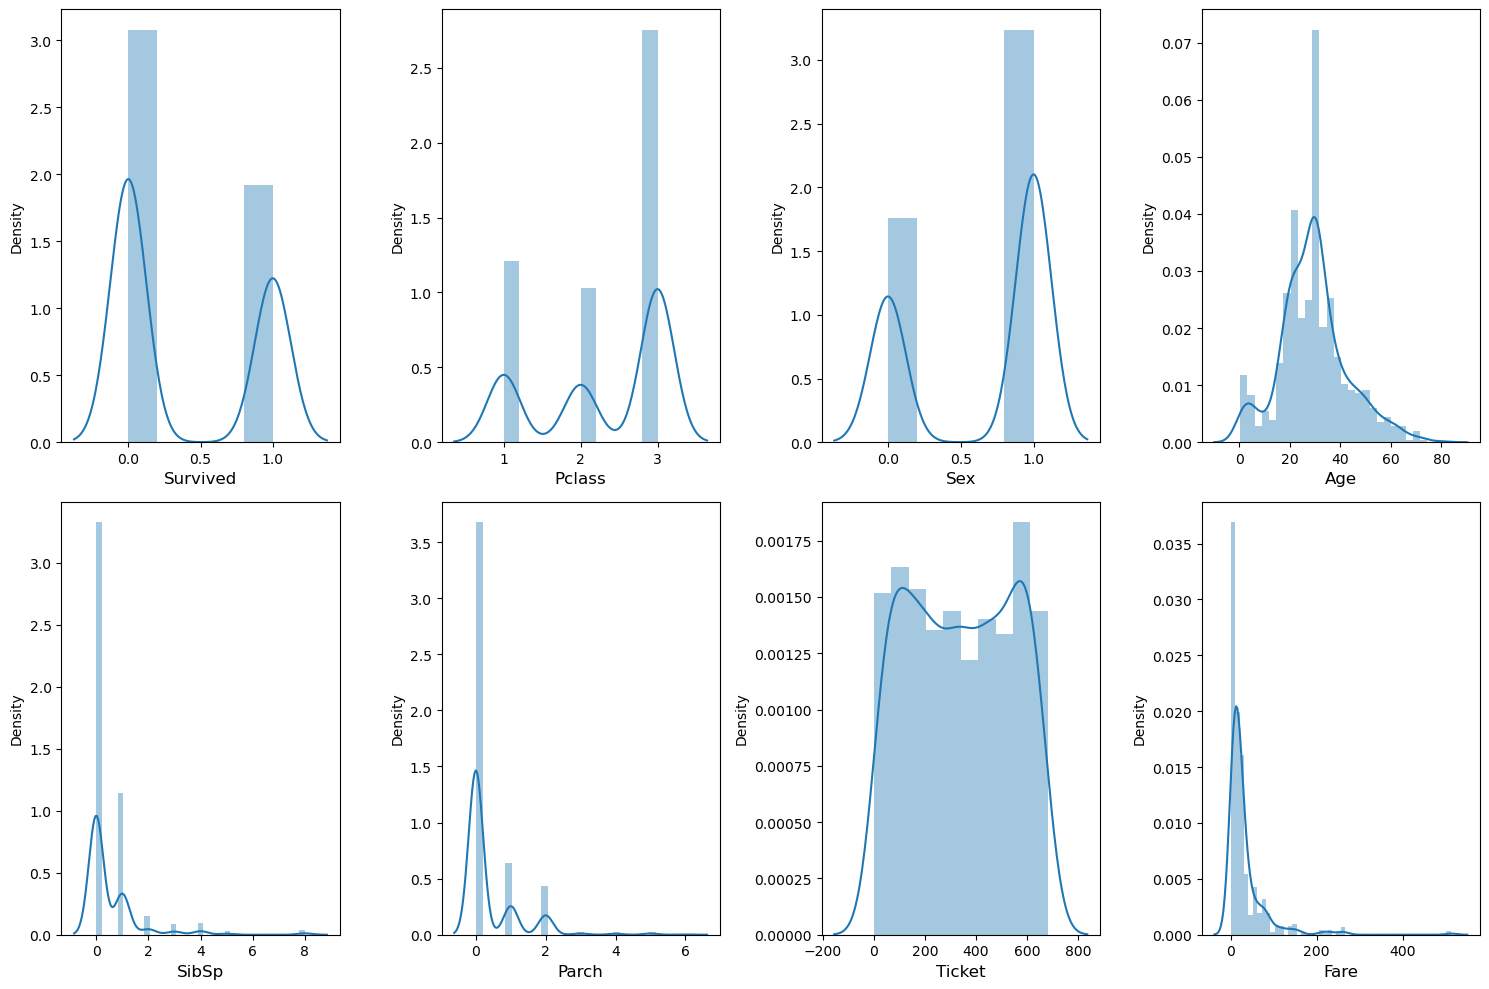

In [44]:
# Check data distribution
plt.figure(figsize=(15,10))
plotnumber=1
for column in df:
    if plotnumber<=8:
        ax=plt.subplot(2,4,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=12)
    plotnumber+=1
plt.tight_layout()

There is left skewness in sibsp, parch and fare. So let's check for outliers using boxplot.

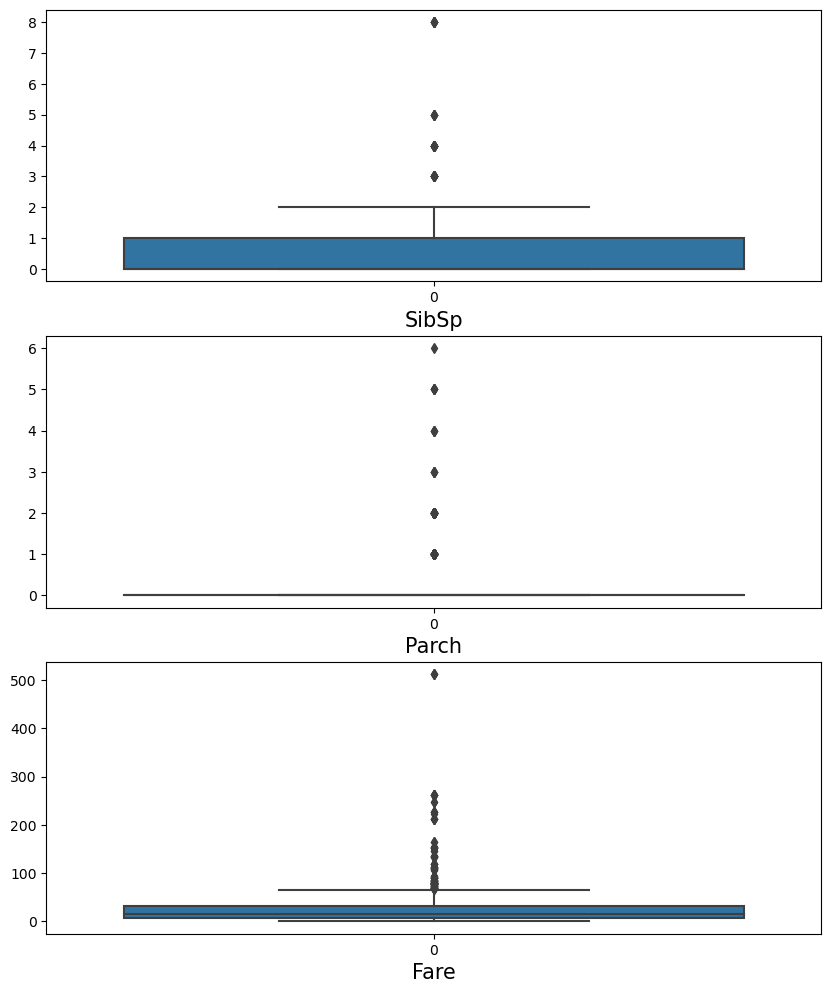

In [46]:
# Check boxplot for outliers
a=df[['SibSp','Parch','Fare']]
plt.figure(figsize=(10,12))
plotnumber=1
for column in a:
    if plotnumber<=3:
        plt.subplot(3,1,plotnumber)
        ax=sns.boxplot(data=a[column])
        plt.xlabel(column, fontsize=15)
    plotnumber+=1
plt.show()

In [47]:
# To remove outliers, use zscore
from scipy.stats import zscore
z=zscore(df[['SibSp','Parch','Fare']])
absz=np.abs(z)
filter=(absz<3).all(axis=1)
df1=df[filter]
df1.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000
mean,0.388150,2.305925,0.660218,29.881705,0.347037,0.253930,332.925030,25.872727
std,0.487624,0.828956,0.473922,12.974864,0.617932,0.563922,201.341696,29.763863
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,153.500000,7.895800
50%,0.000000,3.000000,1.000000,30.000000,0.000000,0.000000,334.000000,13.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,509.500000,27.720800
max,1.000000,3.000000,1.000000,80.000000,3.000000,2.000000,680.000000,164.866700


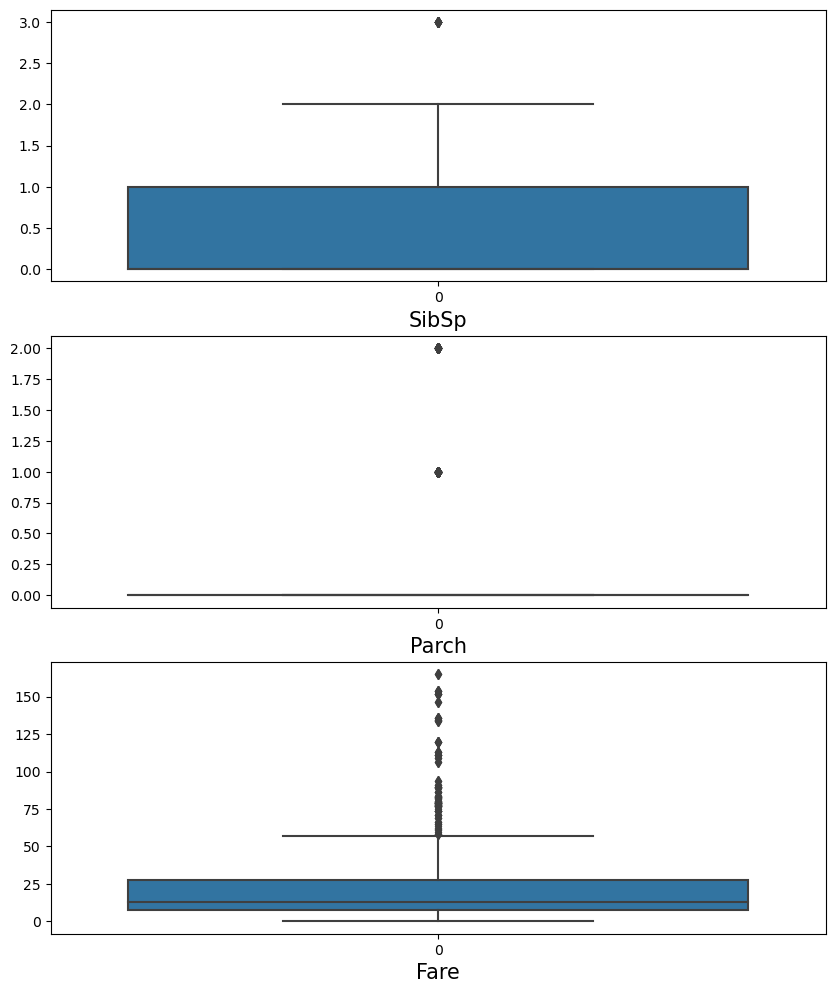

In [48]:
# Check boxplot again for confirming
a=df1[['SibSp','Parch','Fare']]
plt.figure(figsize=(10,12))
plotnumber=1
for column in a:
    if plotnumber<=3:
        plt.subplot(3,1,plotnumber)
        ax=sns.boxplot(data=a[column])
        plt.xlabel(column, fontsize=15)
    plotnumber+=1
plt.show()

Outliers have reduced in 'SibSp','Parch' but not in 'Fare'. We can proceed with the data for now.

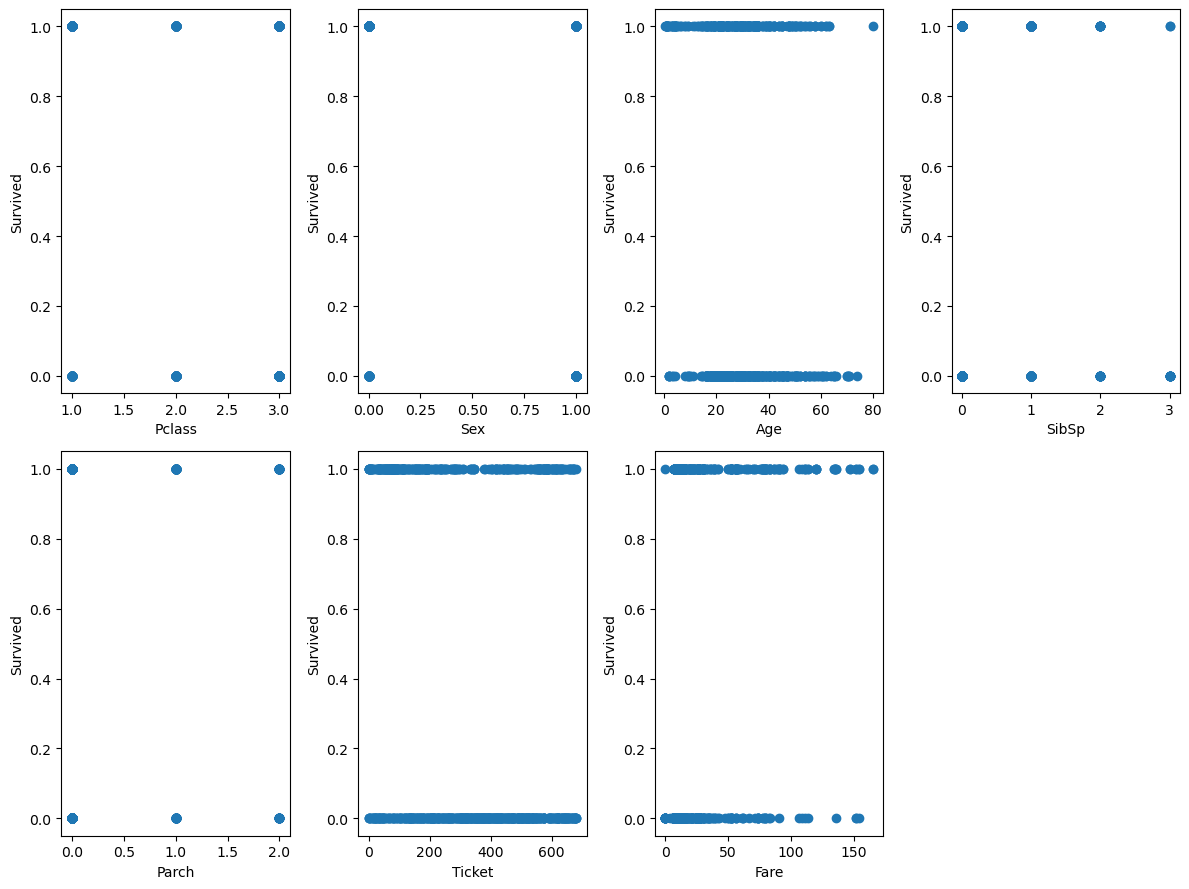

In [49]:
# Check relationship between all features with label

y=df1['Survived']
x=df1.drop(columns=['Survived'])
plt.figure(figsize=(12,9))
plotnumber=1
for column in x:
    if plotnumber<=8:
        ax=plt.subplot(2,4,plotnumber)
        plt.scatter(x[column],y)
        plt.xlabel(column)
        plt.ylabel('Survived')
    plotnumber+=1
plt.tight_layout()

The graph is difficult to be interpreted as they have encoded values in the features.

# Feature Selection

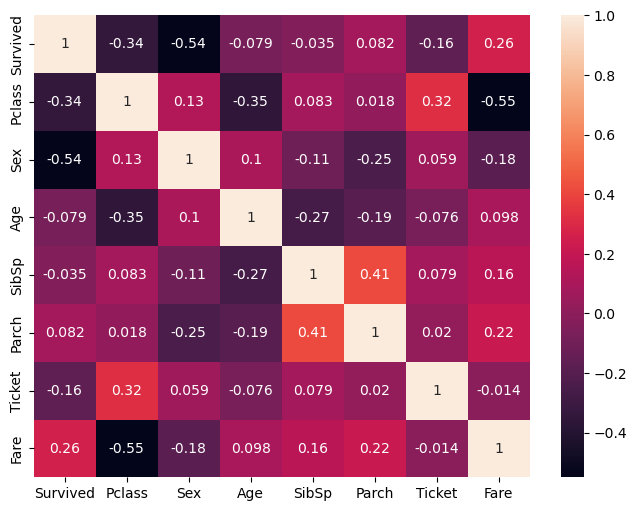

In [53]:
# Check correlation heat map
corrl=df.corr()
plt.figure(figsize=(8, 6)) 
sns.heatmap(corrl,annot=True)
plt.show()

Here,  
High negative correlation (one increases while other decreases): Pclass and fare (-0.55), Sex and survived(-0.54), Pclass and survived (-0.34)

There's positive correlation between: Pclass and ticket, fare and survived, parch and fare

Based on correlation with the label, we can select the following features: Pclass, Sex, Fare and age (since age played a role in choosing children over adults in titanic)


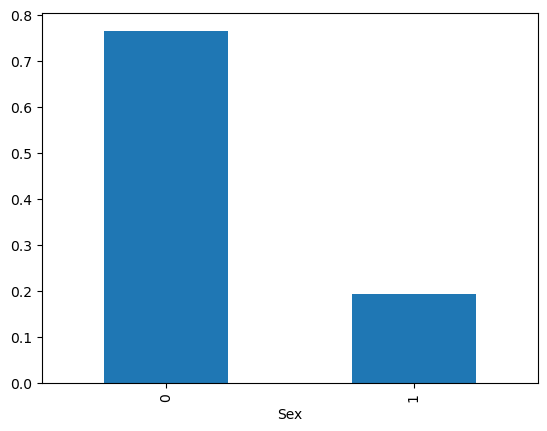

In [103]:
# Graph showing statistics of sex 
abc = df1.groupby('Sex')['Survived'].mean()
abc.plot(kind='bar')
plt.show()

Assuming 0=female, number of females survived is more

# Model Building

Let's build a logistic regression model:

In [59]:
x=df1[['Pclass', 'Sex', 'Fare','Age']]
sc=StandardScaler()
X=sc.fit_transform(x)
y=df1['Survived']

In [65]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=21)

In [76]:
lr=LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression()

In [80]:
def score(model, x_train, x_test, y_train, y_test, train=True):
    if train:
        y_pred = model.predict(x_train)
        print('Accuracy of train set: ', accuracy_score(y_train, y_pred))
    else:
        y_pred2 = model.predict(x_test)
        print('Accuracy of test set: ', accuracy_score(y_test, y_pred2))
        

score(lr, x_train, x_test, y_train, y_test, train=True)
score(lr, x_train, x_test, y_train, y_test, train=False)


Accuracy of train set:  0.7903225806451613
Accuracy of test set:  0.8454106280193237


Accuracy score of both train and test sets are almost near values. But, there's room for improvement, so we can use hyperparameter tuning

In [96]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr,X,y,cv=5).mean()

0.7932238043081418

In [82]:
# HP tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]
}

gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5)

gs.fit(x_train, y_train)

print("Best Train Score:", gs.best_score_)
print("Best Parameters:", gs.best_params_)

Best Train Score: 0.7838709677419355
Best Parameters: {'C': 0.1, 'penalty': 'l2'}


In [86]:
lr1 = LogisticRegression(C=0.1, penalty='l2')
lr1.fit(x_train,y_train)

LogisticRegression(C=0.1)

In [87]:
score(lr1, x_train, x_test, y_train, y_test, train=True)
score(lr1, x_train, x_test, y_train, y_test, train=False)

Accuracy of train set:  0.7887096774193548
Accuracy of test set:  0.8309178743961353


In [97]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr1,X,y,cv=5).mean()

0.7944213216502373

Cross validation score hasnt improved after hp tuning. We'll check roc_auc_score

In [101]:
y_pred=lr1.predict(x_test)

auc=roc_auc_score(y_test,y_pred)
auc

0.8148239715189873

AUC score is 81.4% thereby indicating that model is good!